# **Phase 2: Exploratory Data Analysis (EDA)**

This notebook performs comprehensive exploratory data analysis on the Used Cars Dataset from Kaggle [ https://www.kaggle.com/datasets/austinreese/craigslist-carstrucks-data/data ] after **Phase 1: Data Cleaning & Preprocessing**.

**Objectives:**
- Univariate analysis of target and features
- Bivariate analysis (feature-target relationships)
- Multivariate analysis (feature interactions)
- Geographic analysis (`price` by location)
- Temporal analysis (`price` trends over time)
- Identify key insights for modeling

## **1. Setup & Configuration**

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from scipy import stats
from scipy.stats import pearsonr, spearmanr
import os

# Configuration
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
pd.set_option('display.float_format', '{:.2f}'.format)

# Set random seed
np.random.seed(42)

# Set plot style and color palette
sns.set_style('whitegrid')
COLORS = {
    'primary': '#2E86AB',
    'secondary': '#A23B72',
    'accent': '#F18F01',
    'error': '#C73E1D',
    'success': '#6A994E'
}

In [2]:
# Check GPU availability
import subprocess

try:
    gpu_info = subprocess.check_output(['nvidia-smi', '--query-gpu=name,memory.total', '--format=csv,noheader'])
    print("GPU Available:")
    print(gpu_info.decode('utf-8'))
except:
    print("No GPU detected. Running on CPU.")

GPU Available:
Tesla T4, 15360 MiB



In [3]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Define project paths
PROJECT_ROOT = '/content/drive/MyDrive/Colab Notebooks/CSC 6740 Data Mining/Project/used_car_price_prediction'
DATA_RAW = os.path.join(PROJECT_ROOT, 'data/raw')
DATA_PROCESSED = os.path.join(PROJECT_ROOT, 'data/processed')
RESULTS_FIGURES = os.path.join(PROJECT_ROOT, 'results/figures/eda_plots')

# Create directories if they don't exist
os.makedirs(DATA_PROCESSED, exist_ok=True)
os.makedirs(RESULTS_FIGURES, exist_ok=True)

print(f"Project root: {PROJECT_ROOT}")
print(f"Raw data path: {DATA_RAW}")
print(f"Processed data path: {DATA_PROCESSED}")

Mounted at /content/drive
Project root: /content/drive/MyDrive/Colab Notebooks/CSC 6740 Data Mining/Project/used_car_price_prediction
Raw data path: /content/drive/MyDrive/Colab Notebooks/CSC 6740 Data Mining/Project/used_car_price_prediction/data/raw
Processed data path: /content/drive/MyDrive/Colab Notebooks/CSC 6740 Data Mining/Project/used_car_price_prediction/data/processed


## **2. Load Cleaned Dataset**

In [4]:
# Load cleaned dataset from Phase 1
file_path = os.path.join(DATA_PROCESSED, 'vehicles_cleaned.csv')
df = pd.read_csv(file_path)

print(f"Dataset loaded successfully!")
print(f"Shape: {df.shape}")
print(f"Memory usage: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

Dataset loaded successfully!
Shape: (348001, 19)
Memory usage: 256.89 MB


In [7]:
# Convert posting_date from object to datetime64[ns]
if 'posting_date' in df.columns:
    df['posting_date'] = pd.to_datetime(df['posting_date'])
    print(f"\nConverted 'posting_date' to datetime64")
    print(f"posting_date dtype: {df['posting_date'].dtype}")

# Convert categorical columns back to category dtype
categorical_features = ['region', 'manufacturer', 'model', 'condition', 'cylinders',
                       'fuel', 'title_status', 'transmission', 'drive',
                       'type', 'paint_color', 'state']

for feature in categorical_features:
    if feature in df.columns:
        df[feature] = df[feature].astype('category')

print("\nData types optimized!")


Converted 'posting_date' to datetime64
posting_date dtype: datetime64[ns]

Data types optimized!


In [8]:
# Display first few rows
df.head()

,id,region,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,drive,type,paint_color,state,lat,long,posting_date
0,7316814884,auburn,33590,2014,gmc,sierra 1500 crew cab slt,good,8 cylinders,gas,57923,clean,other,unknown,pickup,white,al,32.59,-85.48,2021-05-04
1,7316814758,auburn,22590,2010,chevrolet,silverado 1500,good,8 cylinders,gas,71229,clean,other,unknown,pickup,blue,al,32.59,-85.48,2021-05-04
2,7316814989,auburn,39590,2020,chevrolet,silverado 1500 crew,good,8 cylinders,gas,19160,clean,other,unknown,pickup,red,al,32.59,-85.48,2021-05-04
3,7316743432,auburn,30990,2017,toyota,tundra double cab sr,good,8 cylinders,gas,41124,clean,other,unknown,pickup,red,al,32.59,-85.48,2021-05-04
4,7316356412,auburn,15000,2013,ford,f-150 xlt,excellent,6 cylinders,gas,128000,clean,automatic,rwd,truck,black,al,32.59,-85.52,2021-05-03


In [9]:
# Dataset information
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 348001 entries, 0 to 348000
Data columns (total 19 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   id            348001 non-null  int64         
 1   region        348001 non-null  category      
 2   price         348001 non-null  int64         
 3   year          348001 non-null  int64         
 4   manufacturer  348001 non-null  category      
 5   model         348001 non-null  category      
 6   condition     348001 non-null  category      
 7   cylinders     348001 non-null  category      
 8   fuel          348001 non-null  category      
 9   odometer      348001 non-null  int64         
 10  title_status  348001 non-null  category      
 11  transmission  348001 non-null  category      
 12  drive         348001 non-null  category      
 13  type          348001 non-null  category      
 14  paint_color   348001 non-null  category      
 15  state         348

## **3. Univariate Analysis**

Analyzing the distribution of individual features.

### **3.1 Target Variable: Price**

In [10]:
# Price statistics
print("Price Distribution Statistics:")
print("=" * 60)
print(df['price'].describe())
print(f"\nSkewness: {df['price'].skew():.3f}")
print(f"Kurtosis: {df['price'].kurtosis():.3f}")
print("=" * 60)

Price Distribution Statistics:
count   348001.00
mean     18077.00
std      12595.23
min        150.00
25%       7500.00
50%      15400.00
75%      26990.00
max      56255.00
Name: price, dtype: float64

Skewness: 0.693
Kurtosis: -0.350


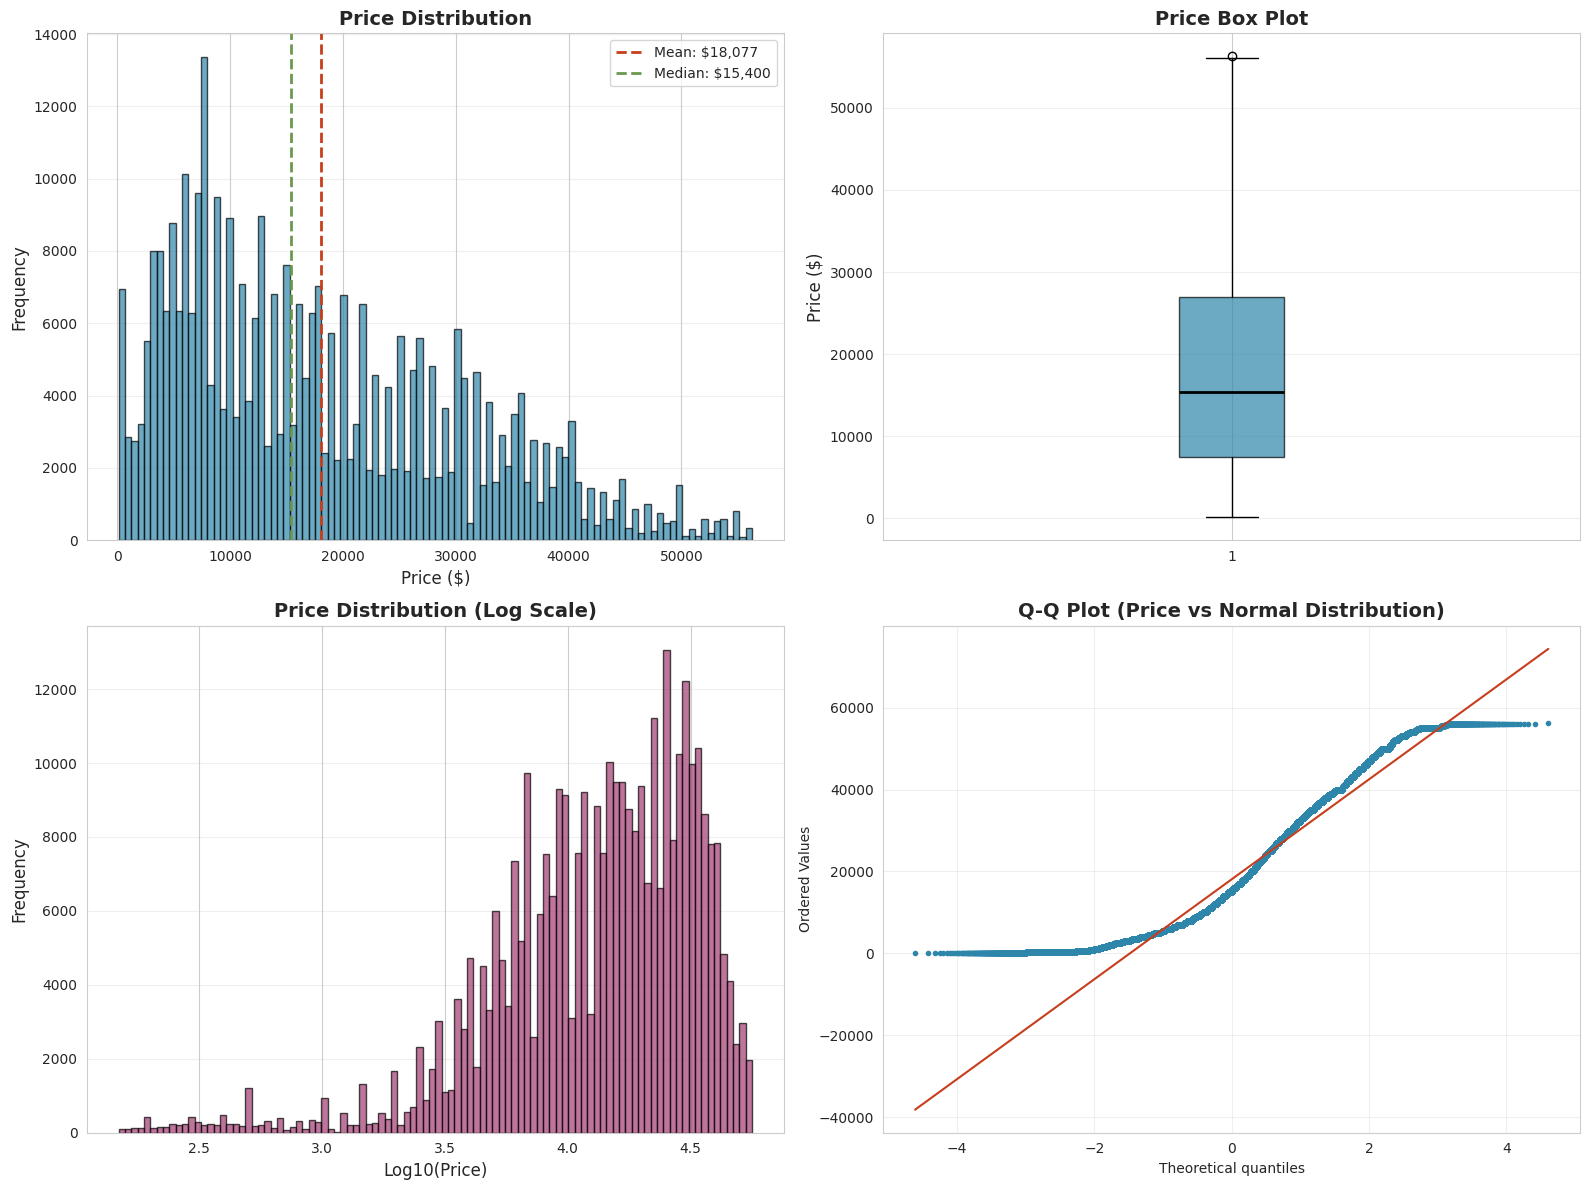

Figure saved: eda_01_price_distribution.png


In [11]:
# Price distribution visualizations
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Histogram
axes[0, 0].hist(df['price'], bins=100, color=COLORS['primary'], edgecolor='black', alpha=0.7)
axes[0, 0].axvline(df['price'].mean(), color=COLORS['error'], linestyle='--', linewidth=2, label=f'Mean: ${df["price"].mean():,.0f}')
axes[0, 0].axvline(df['price'].median(), color=COLORS['success'], linestyle='--', linewidth=2, label=f'Median: ${df["price"].median():,.0f}')
axes[0, 0].set_xlabel('Price ($)', fontsize=12)
axes[0, 0].set_ylabel('Frequency', fontsize=12)
axes[0, 0].set_title('Price Distribution', fontsize=14, fontweight='bold')
axes[0, 0].legend()
axes[0, 0].grid(axis='y', alpha=0.3)

# Box plot
axes[0, 1].boxplot(df['price'], vert=True, patch_artist=True,
                   boxprops=dict(facecolor=COLORS['primary'], alpha=0.7),
                   medianprops=dict(color='black', linewidth=2))
axes[0, 1].set_ylabel('Price ($)', fontsize=12)
axes[0, 1].set_title('Price Box Plot', fontsize=14, fontweight='bold')
axes[0, 1].grid(axis='y', alpha=0.3)

# Log-transformed histogram
axes[1, 0].hist(np.log10(df['price']), bins=100, color=COLORS['secondary'], edgecolor='black', alpha=0.7)
axes[1, 0].set_xlabel('Log10(Price)', fontsize=12)
axes[1, 0].set_ylabel('Frequency', fontsize=12)
axes[1, 0].set_title('Price Distribution (Log Scale)', fontsize=14, fontweight='bold')
axes[1, 0].grid(axis='y', alpha=0.3)

# Q-Q plot (normality test)
stats.probplot(df['price'], dist="norm", plot=axes[1, 1])
axes[1, 1].get_lines()[0].set_color(COLORS['primary'])
axes[1, 1].get_lines()[0].set_markersize(3)
axes[1, 1].get_lines()[1].set_color(COLORS['error'])
axes[1, 1].set_title('Q-Q Plot (Price vs Normal Distribution)', fontsize=14, fontweight='bold')
axes[1, 1].grid(alpha=0.3)

plt.tight_layout()
plt.savefig(os.path.join(RESULTS_FIGURES, 'eda_01_price_distribution.png'), dpi=300, bbox_inches='tight')
plt.show()

print("Figure saved: eda_01_price_distribution.png")

### **3.2 Numerical Features**

In [12]:
# Numerical features statistics
numerical_features = ['year', 'odometer', 'lat', 'long']

print("Numerical Features Statistics:")
print("=" * 80)
print(df[numerical_features].describe())
print("=" * 80)

Numerical Features Statistics:
           year  odometer       lat      long
count 348001.00 348001.00 348001.00 348001.00
mean    2012.39  94327.15     38.46    -93.22
std        5.45  59883.45      5.21     16.57
min     1995.00    220.00     24.56   -124.43
25%     2009.00  41512.00     34.86   -106.59
50%     2013.00  90937.00     39.26    -87.54
75%     2017.00 137000.00     42.32    -80.63
max     2020.00 273000.00     49.00    -67.14


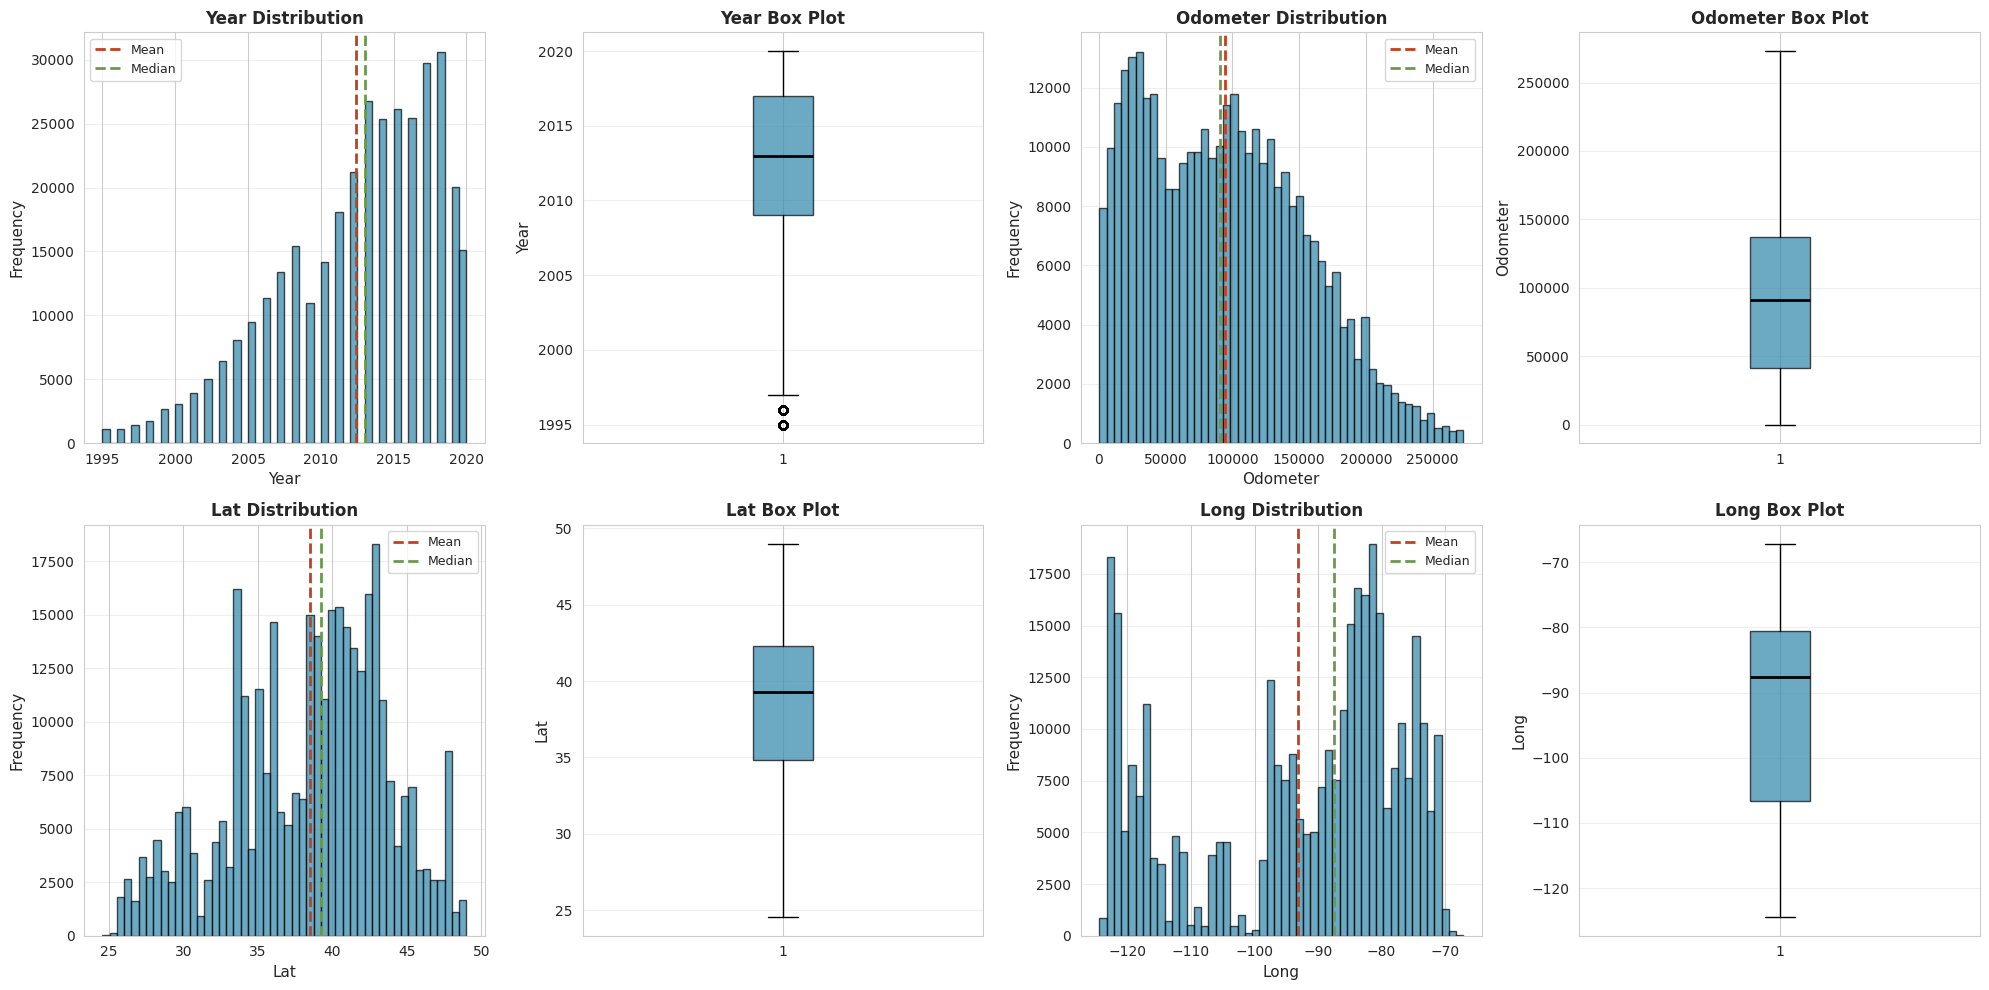

Figure saved: eda_02_numerical_distributions.png


In [13]:
# Distribution of numerical features
fig, axes = plt.subplots(2, 4, figsize=(20, 10))

for idx, feature in enumerate(numerical_features):
    row = idx // 2
    col_hist = (idx % 2) * 2
    col_box = col_hist + 1

    # Histogram
    axes[row, col_hist].hist(df[feature], bins=50, color=COLORS['primary'],
                             edgecolor='black', alpha=0.7)
    axes[row, col_hist].axvline(df[feature].mean(), color=COLORS['error'],
                                linestyle='--', linewidth=2, label='Mean')
    axes[row, col_hist].axvline(df[feature].median(), color=COLORS['success'],
                                linestyle='--', linewidth=2, label='Median')
    axes[row, col_hist].set_xlabel(feature.title(), fontsize=11)
    axes[row, col_hist].set_ylabel('Frequency', fontsize=11)
    axes[row, col_hist].set_title(f'{feature.title()} Distribution', fontsize=12, fontweight='bold')
    axes[row, col_hist].legend(fontsize=9)
    axes[row, col_hist].grid(axis='y', alpha=0.3)

    # Box plot
    axes[row, col_box].boxplot(df[feature], vert=True, patch_artist=True,
                               boxprops=dict(facecolor=COLORS['primary'], alpha=0.7),
                               medianprops=dict(color='black', linewidth=2))
    axes[row, col_box].set_ylabel(feature.title(), fontsize=11)
    axes[row, col_box].set_title(f'{feature.title()} Box Plot', fontsize=12, fontweight='bold')
    axes[row, col_box].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig(os.path.join(RESULTS_FIGURES, 'eda_02_numerical_distributions.png'), dpi=300, bbox_inches='tight')
plt.show()

print("Figure saved: eda_02_numerical_distributions.png")

### **3.3 Categorical Features**

In [14]:
# Categorical features summary
print("Categorical Features Summary:")
print("=" * 80)

categorical_features = ['region', 'manufacturer', 'model', 'condition', 'cylinders',
                        'fuel', 'title_status', 'transmission', 'drive', 'type',
                        'paint_color', 'state']

cat_summary = []
for feature in categorical_features:
    if feature in df.columns:
        n_unique = df[feature].nunique()
        most_common = df[feature].mode()[0]
        most_common_freq = (df[feature] == most_common).sum()
        most_common_pct = (most_common_freq / len(df)) * 100

        cat_summary.append({
            'Feature': feature,
            'Unique_Values': n_unique,
            'Most_Common': most_common,
            'Frequency': most_common_freq,
            'Percentage': f'{most_common_pct:.2f}%'
        })

cat_summary_df = pd.DataFrame(cat_summary)
print(cat_summary_df.to_string(index=False))
print("=" * 80)

Categorical Features Summary:
     Feature  Unique_Values Most_Common  Frequency Percentage
      region            403    columbus       3087      0.89%
manufacturer             42        ford      56384     16.20%
       model          21907       f-150       6386      1.84%
   condition              7     unknown     129487     37.21%
   cylinders              9     unknown     143229     41.16%
        fuel              6         gas     294495     84.62%
title_status              7       clean     329456     94.67%
transmission              4   automatic     271245     77.94%
       drive              4     unknown     105816     30.41%
        type             14       sedan      74792     21.49%
 paint_color             13     unknown     101436     29.15%
       state             51          ca      40433     11.62%


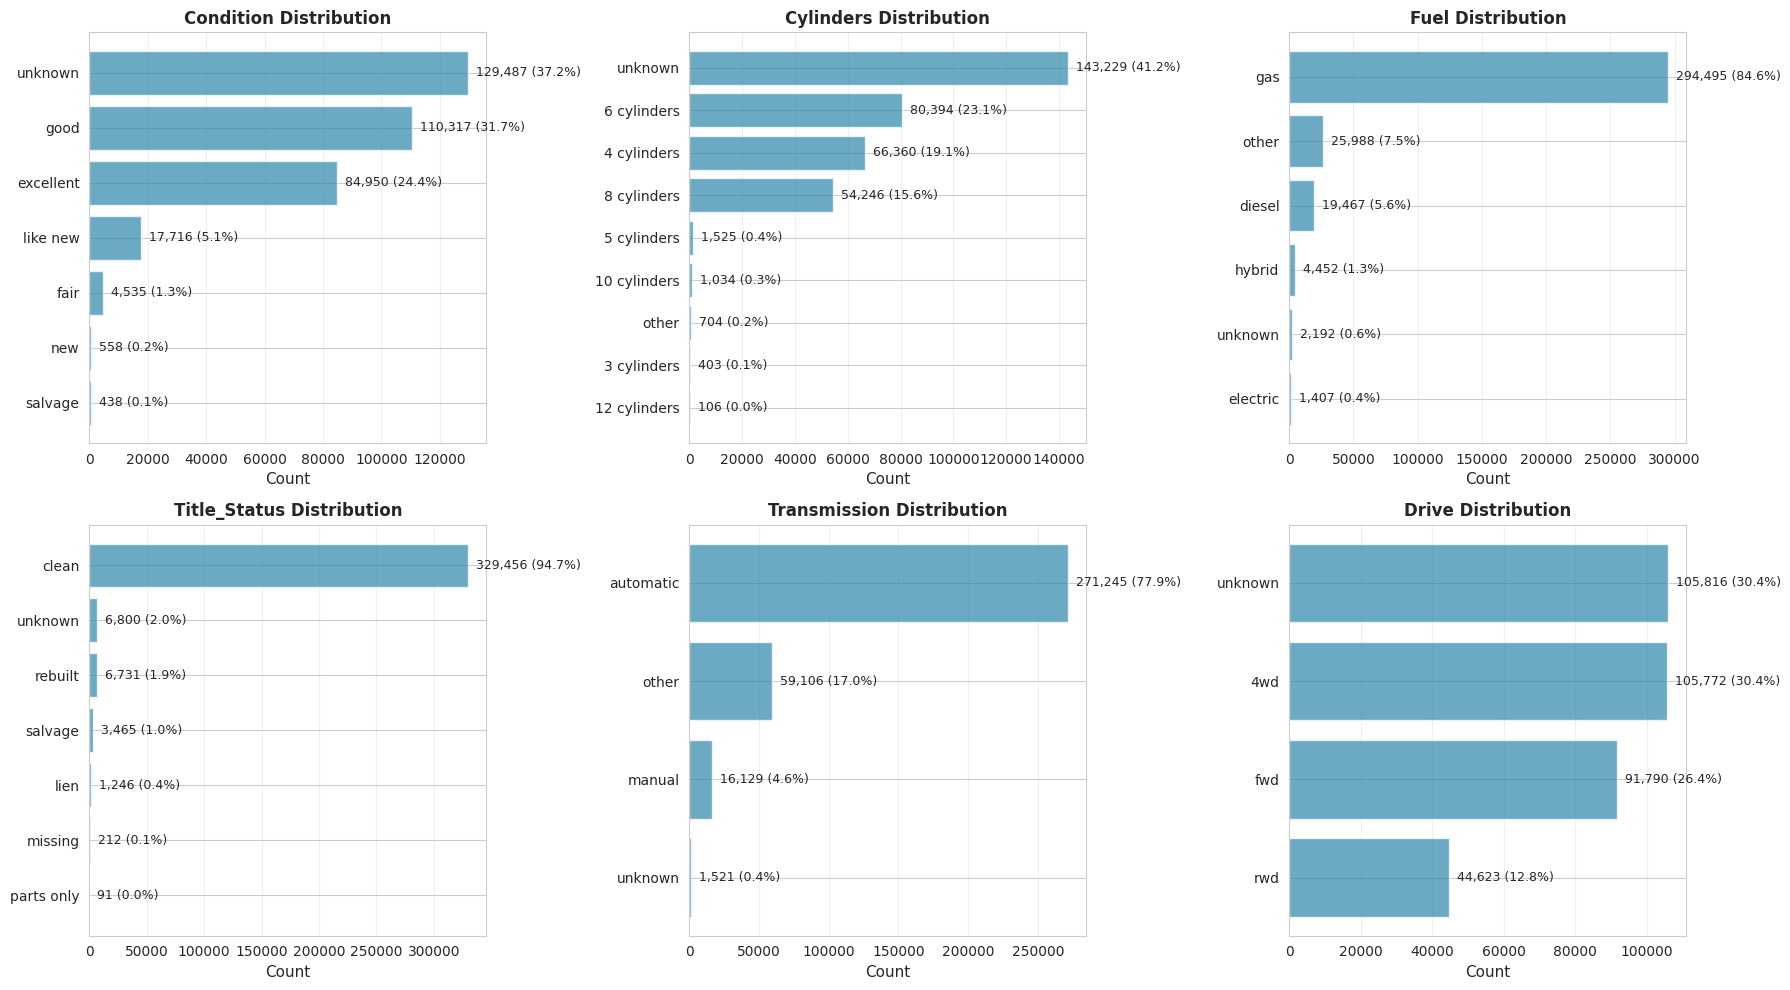

Figure saved: eda_03_categorical_distributions.png


In [15]:
# Visualize low-cardinality categorical features
low_card_features = ['condition', 'cylinders', 'fuel', 'title_status', 'transmission', 'drive']
low_card_features = [f for f in low_card_features if f in df.columns]

n_features = len(low_card_features)
n_cols = 3
n_rows = (n_features + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, 5 * n_rows))
axes = axes.flatten() if n_features > 1 else [axes]

for idx, feature in enumerate(low_card_features):
    value_counts = df[feature].value_counts().head(10)

    axes[idx].barh(range(len(value_counts)), value_counts.values,
                   color=COLORS['primary'], alpha=0.7)
    axes[idx].set_yticks(range(len(value_counts)))
    axes[idx].set_yticklabels(value_counts.index, fontsize=10)
    axes[idx].set_xlabel('Count', fontsize=11)
    axes[idx].set_title(f'{feature.title()} Distribution', fontsize=12, fontweight='bold')
    axes[idx].grid(axis='x', alpha=0.3)
    axes[idx].invert_yaxis()

    # Add percentage labels
    for i, v in enumerate(value_counts.values):
        pct = (v / len(df)) * 100
        axes[idx].text(v, i, f'  {v:,} ({pct:.1f}%)', va='center', fontsize=9)

# Hide unused subplots
for idx in range(n_features, len(axes)):
    axes[idx].axis('off')

plt.tight_layout()
plt.savefig(os.path.join(RESULTS_FIGURES, 'eda_03_categorical_distributions.png'), dpi=300, bbox_inches='tight')
plt.show()

print("Figure saved: eda_03_categorical_distributions.png")

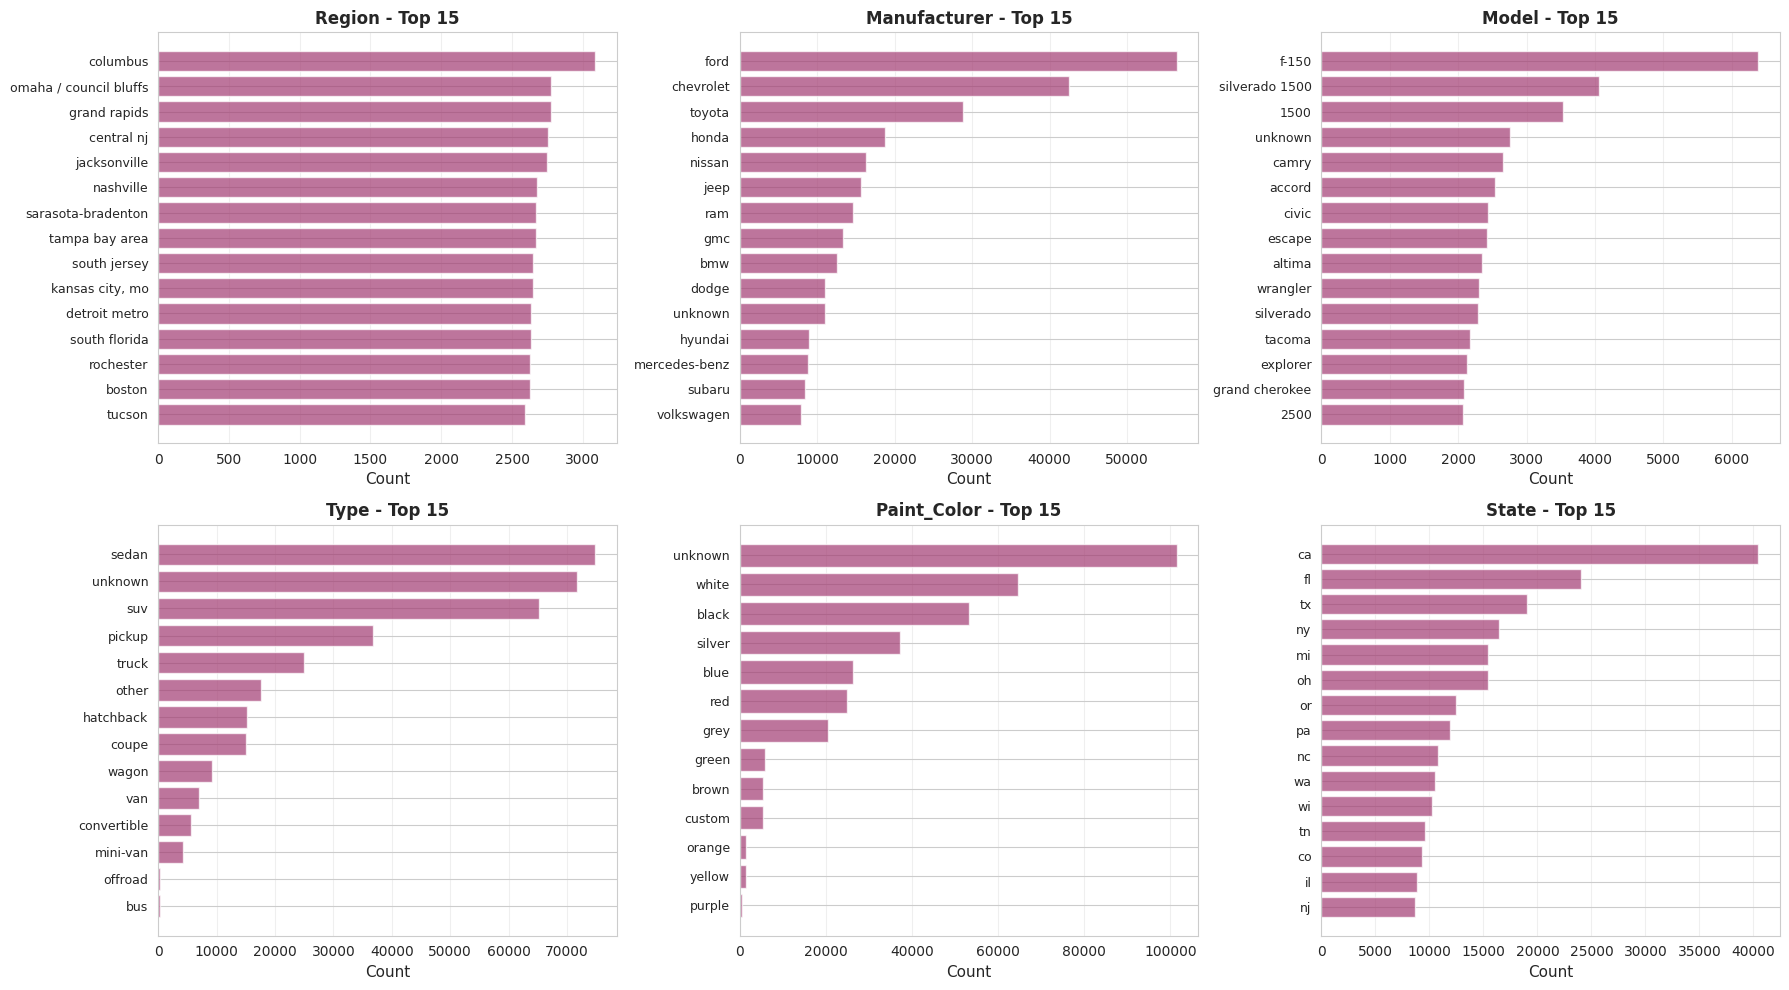

Figure saved: eda_04_high_cardinality_features.png


In [16]:
# Visualize high-cardinality categorical features (top 15)
high_card_features = ['region', 'manufacturer', 'model', 'type', 'paint_color', 'state']
high_card_features = [f for f in high_card_features if f in df.columns]

n_features = len(high_card_features)
n_cols = 3
n_rows = (n_features + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, 5 * n_rows))
axes = axes.flatten() if n_features > 1 else [axes]

for idx, feature in enumerate(high_card_features):
    value_counts = df[feature].value_counts().head(15)

    axes[idx].barh(range(len(value_counts)), value_counts.values,
                   color=COLORS['secondary'], alpha=0.7)
    axes[idx].set_yticks(range(len(value_counts)))
    axes[idx].set_yticklabels(value_counts.index, fontsize=9)
    axes[idx].set_xlabel('Count', fontsize=11)
    axes[idx].set_title(f'{feature.title()} - Top 15', fontsize=12, fontweight='bold')
    axes[idx].grid(axis='x', alpha=0.3)
    axes[idx].invert_yaxis()

plt.tight_layout()
plt.savefig(os.path.join(RESULTS_FIGURES, 'eda_04_high_cardinality_features.png'), dpi=300, bbox_inches='tight')
plt.show()

print("Figure saved: eda_04_high_cardinality_features.png")

## **4. Bivariate Analysis**

Analyzing relationships between features and the target variable (`price`).

### **4.1 Numerical Features vs. `price`**

In [17]:
# Correlation analysis
numerical_cols = ['price', 'year', 'odometer', 'lat', 'long']
correlation_matrix = df[numerical_cols].corr()

print("Correlation with Price:")
print("=" * 40)
price_corr = correlation_matrix['price'].sort_values(ascending=False)
for feature, corr in price_corr.items():
    if feature != 'price':
        print(f"{feature:15s}: {corr:6.3f}")
print("=" * 40)

Correlation with Price:
year           :  0.600
lat            : -0.035
long           : -0.040
odometer       : -0.563


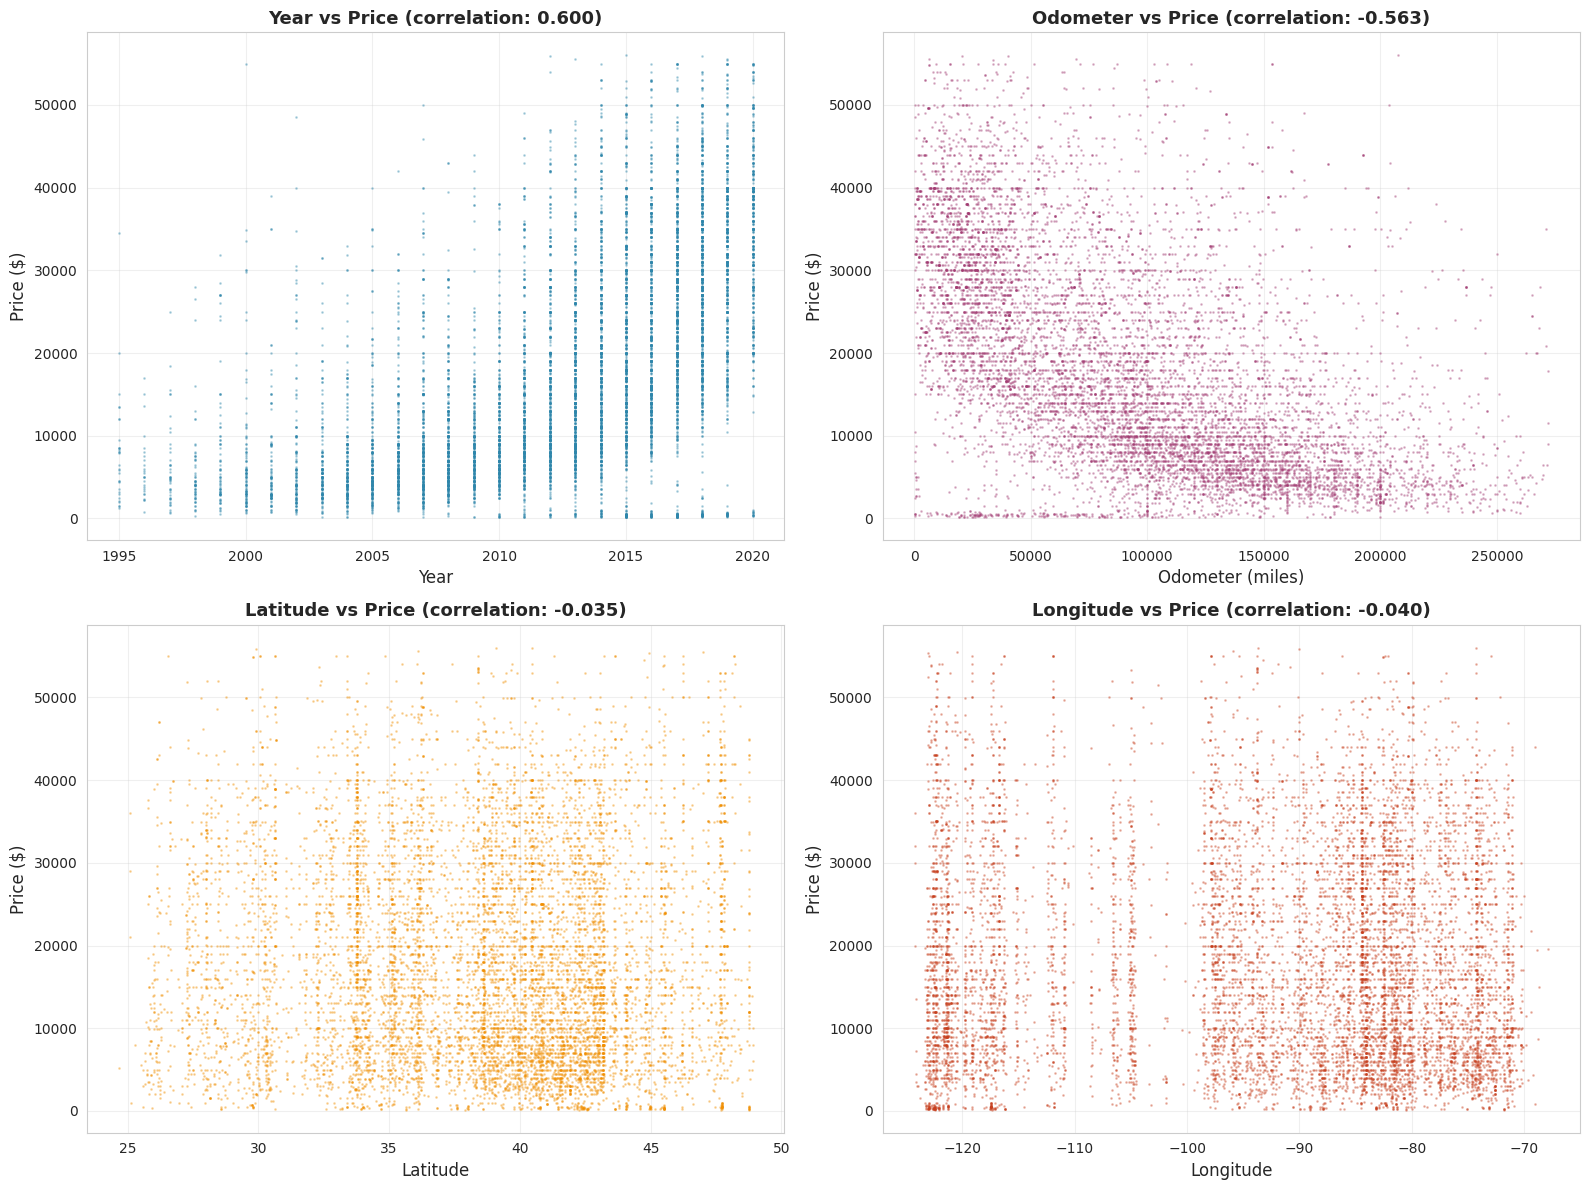

Figure saved: eda_05_numerical_vs_price.png


In [18]:
# Scatter plots: Numerical features vs. Price
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Sample data for performance (max 10000 points per plot)
sample_size = min(10000, len(df))
df_sample = df.sample(sample_size, random_state=42)

# Year vs Price
axes[0, 0].scatter(df_sample['year'], df_sample['price'], alpha=0.3, s=1, color=COLORS['primary'])
axes[0, 0].set_xlabel('Year', fontsize=12)
axes[0, 0].set_ylabel('Price ($)', fontsize=12)
axes[0, 0].set_title(f'Year vs Price (correlation: {price_corr["year"]:.3f})',
                     fontsize=13, fontweight='bold')
axes[0, 0].grid(alpha=0.3)

# Odometer vs Price
axes[0, 1].scatter(df_sample['odometer'], df_sample['price'], alpha=0.3, s=1, color=COLORS['secondary'])
axes[0, 1].set_xlabel('Odometer (miles)', fontsize=12)
axes[0, 1].set_ylabel('Price ($)', fontsize=12)
axes[0, 1].set_title(f'Odometer vs Price (correlation: {price_corr["odometer"]:.3f})',
                     fontsize=13, fontweight='bold')
axes[0, 1].grid(alpha=0.3)

# Latitude vs Price
axes[1, 0].scatter(df_sample['lat'], df_sample['price'], alpha=0.3, s=1, color=COLORS['accent'])
axes[1, 0].set_xlabel('Latitude', fontsize=12)
axes[1, 0].set_ylabel('Price ($)', fontsize=12)
axes[1, 0].set_title(f'Latitude vs Price (correlation: {price_corr["lat"]:.3f})',
                     fontsize=13, fontweight='bold')
axes[1, 0].grid(alpha=0.3)

# Longitude vs Price
axes[1, 1].scatter(df_sample['long'], df_sample['price'], alpha=0.3, s=1, color=COLORS['error'])
axes[1, 1].set_xlabel('Longitude', fontsize=12)
axes[1, 1].set_ylabel('Price ($)', fontsize=12)
axes[1, 1].set_title(f'Longitude vs Price (correlation: {price_corr["long"]:.3f})',
                     fontsize=13, fontweight='bold')
axes[1, 1].grid(alpha=0.3)

plt.tight_layout()
plt.savefig(os.path.join(RESULTS_FIGURES, 'eda_05_numerical_vs_price.png'), dpi=300, bbox_inches='tight')
plt.show()

print("Figure saved: eda_05_numerical_vs_price.png")

### **4.2 Categorical Features vs. `price`**

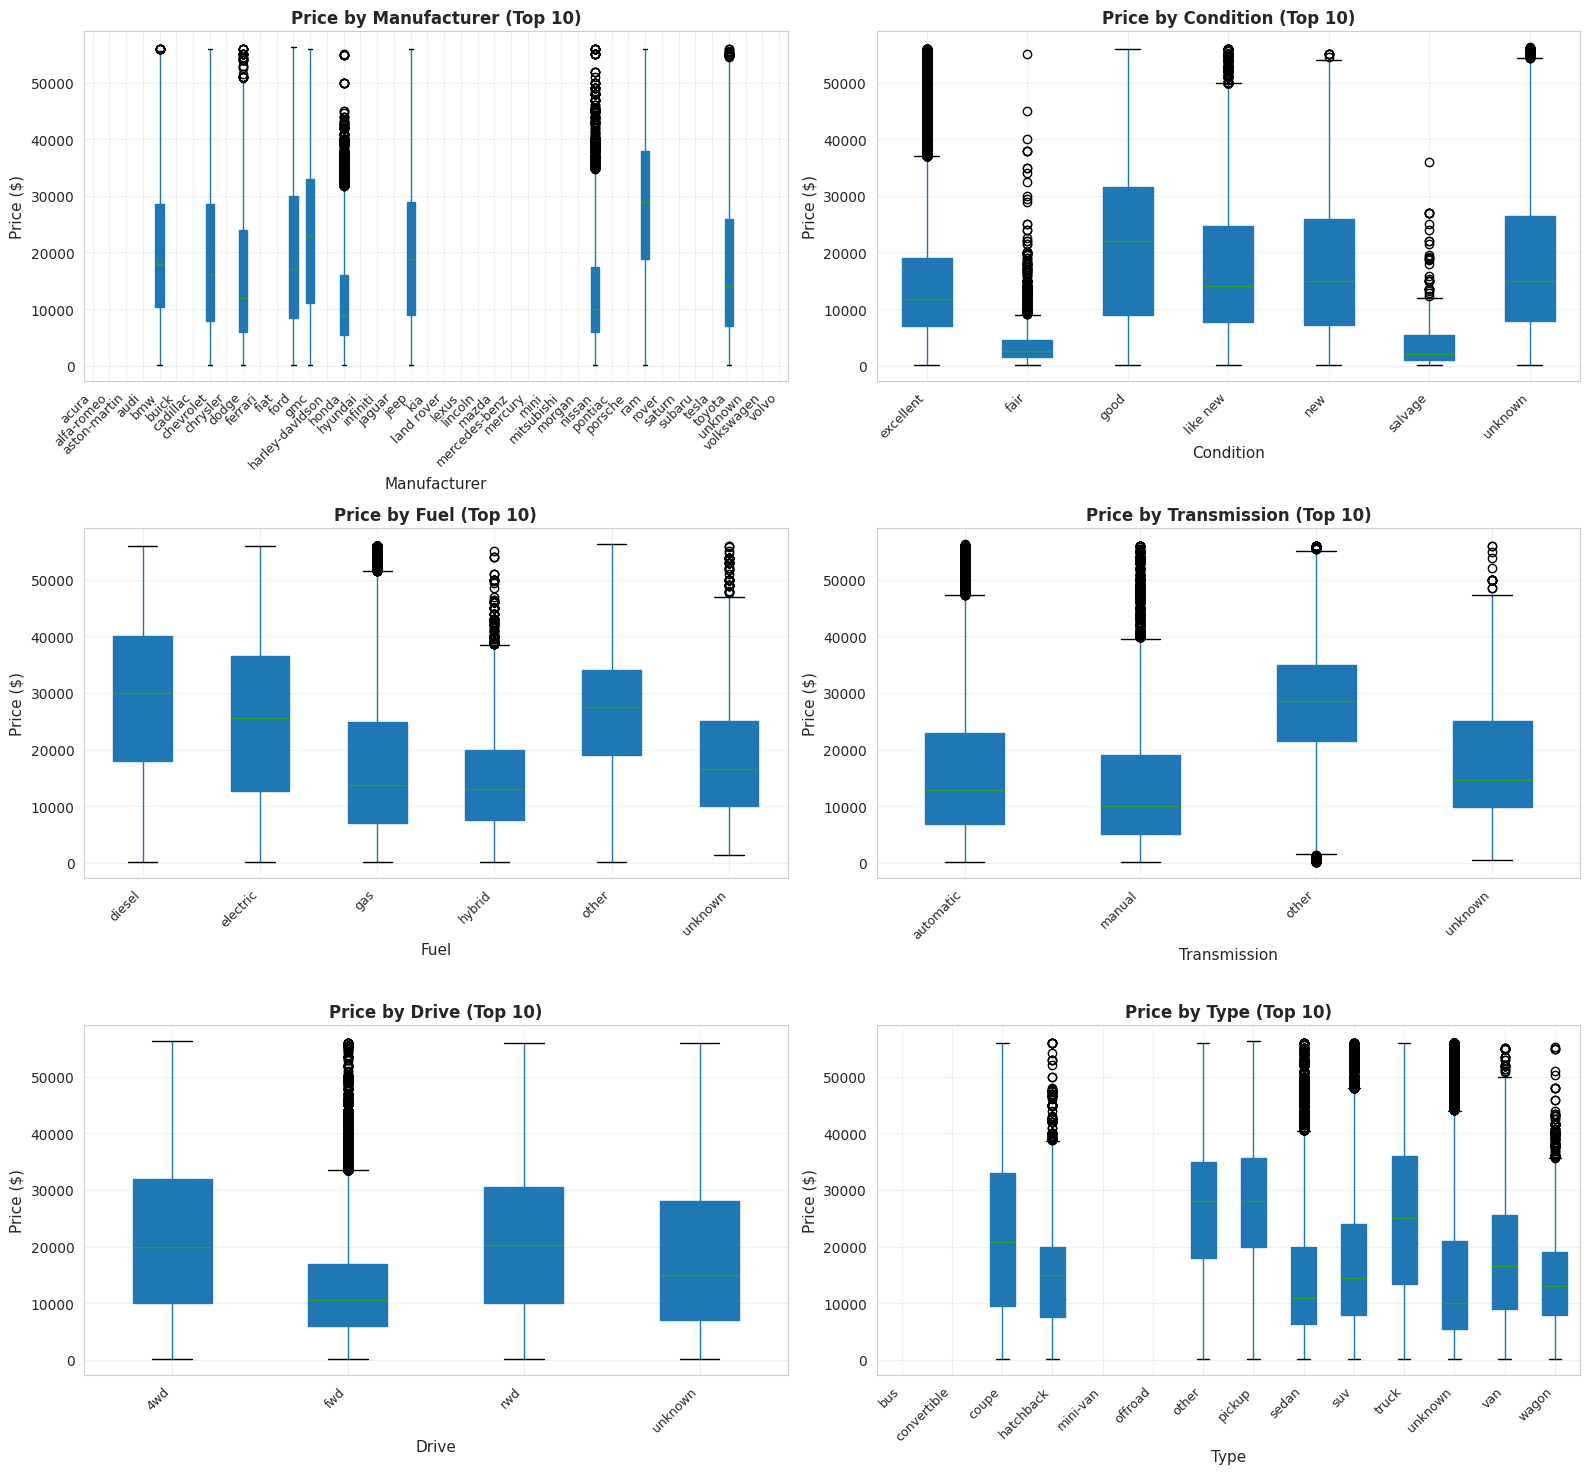

Figure saved: eda_06_categorical_vs_price.png


In [19]:
# Box plots: Key categorical features vs. Price
key_cat_features = ['manufacturer', 'condition', 'fuel', 'transmission', 'drive', 'type']
key_cat_features = [f for f in key_cat_features if f in df.columns]

n_features = len(key_cat_features)
n_cols = 2
n_rows = (n_features + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(16, 5 * n_rows))
axes = axes.flatten() if n_features > 1 else [axes]

for idx, feature in enumerate(key_cat_features):
    # Get top categories by frequency
    top_categories = df[feature].value_counts().head(10).index
    df_subset = df[df[feature].isin(top_categories)]

    # Create box plot
    df_subset.boxplot(column='price', by=feature, ax=axes[idx], patch_artist=True)
    axes[idx].set_xlabel(feature.title(), fontsize=11)
    axes[idx].set_ylabel('Price ($)', fontsize=11)
    axes[idx].set_title(f'Price by {feature.title()} (Top 10)', fontsize=12, fontweight='bold')
    axes[idx].tick_params(axis='x', rotation=45, labelsize=9)
    axes[idx].grid(alpha=0.3)
    plt.setp(axes[idx].xaxis.get_majorticklabels(), rotation=45, ha='right')

# Hide unused subplots
for idx in range(n_features, len(axes)):
    axes[idx].axis('off')

plt.suptitle('')  # Remove default title
plt.tight_layout()
plt.savefig(os.path.join(RESULTS_FIGURES, 'eda_06_categorical_vs_price.png'), dpi=300, bbox_inches='tight')
plt.show()

print("Figure saved: eda_06_categorical_vs_price.png")

In [20]:
# Average price by category
print("Average Price by Key Categories:")
print("=" * 80)

for feature in ['manufacturer', 'condition', 'fuel', 'transmission', 'type']:
    if feature in df.columns:
        avg_price = df.groupby(feature)['price'].agg(['mean', 'median', 'count']).sort_values('mean', ascending=False)
        print(f"\n{feature.upper()} - Top 10 by Average Price:")
        print(avg_price.head(10).to_string())
        print("-" * 80)

Average Price by Key Categories:

MANUFACTURER - Top 10 by Average Price:
                 mean   median  count
manufacturer                         
tesla        35961.72 37590.00    739
alfa-romeo   30155.62 29900.00    773
ram          28295.10 29000.00  14589
aston-martin 27834.82 37000.00     11
porsche      27188.37 27990.00    996
jaguar       26693.33 28590.00   1684
rover        25059.41 23997.00   1705
audi         23588.35 23998.00   6659
gmc          22924.21 22995.00  13353
infiniti     21224.74 21590.00   4346
--------------------------------------------------------------------------------

CONDITION - Top 10 by Average Price:
              mean   median   count
condition                          
good      21349.63 21990.00  110317
unknown   18244.67 14995.00  129487
new       18045.15 14875.00     558
like new  17227.48 13995.00   17716
excellent 14591.91 11850.00   84950
salvage    4147.71  2000.00     438
fair       3631.77  2600.00    4535
---------------------------

## **5. Multivariate Analysis**

### **5.1 Correlation Matrix**

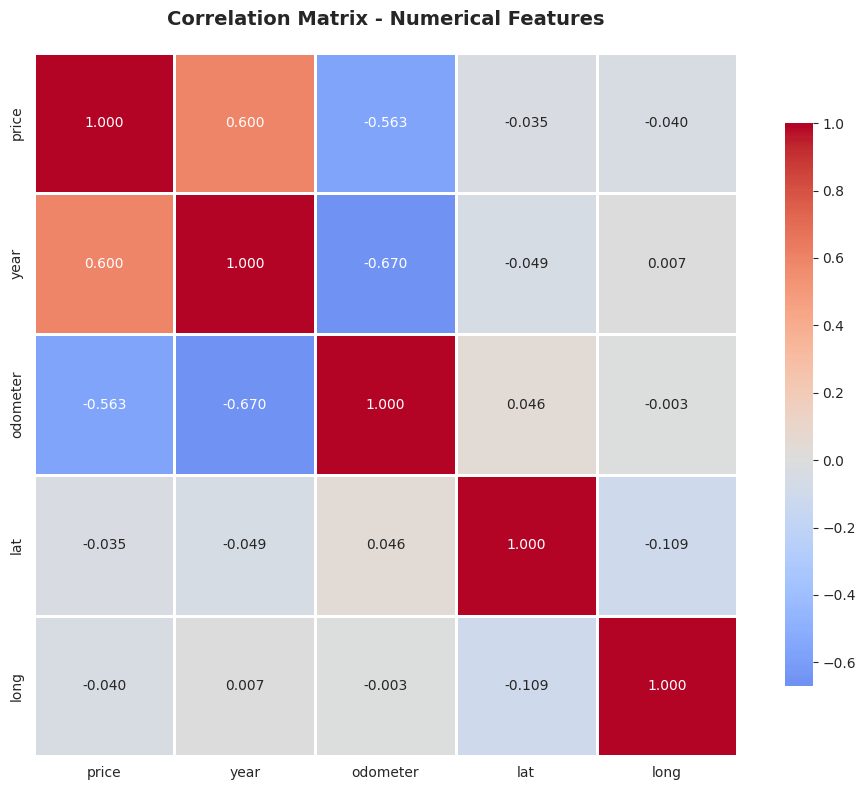

Figure saved: eda_07_correlation_matrix.png


In [21]:
# Correlation heatmap for numerical features
fig, ax = plt.subplots(figsize=(10, 8))

# Create correlation matrix
corr_matrix = df[numerical_cols].corr()

# Create heatmap
sns.heatmap(corr_matrix, annot=True, fmt='.3f', cmap='coolwarm', center=0,
            square=True, linewidths=1, cbar_kws={"shrink": 0.8}, ax=ax)
ax.set_title('Correlation Matrix - Numerical Features', fontsize=14, fontweight='bold', pad=20)

plt.tight_layout()
plt.savefig(os.path.join(RESULTS_FIGURES, 'eda_07_correlation_matrix.png'), dpi=300, bbox_inches='tight')
plt.show()

print("Figure saved: eda_07_correlation_matrix.png")

### **5.2 Feature Interactions**

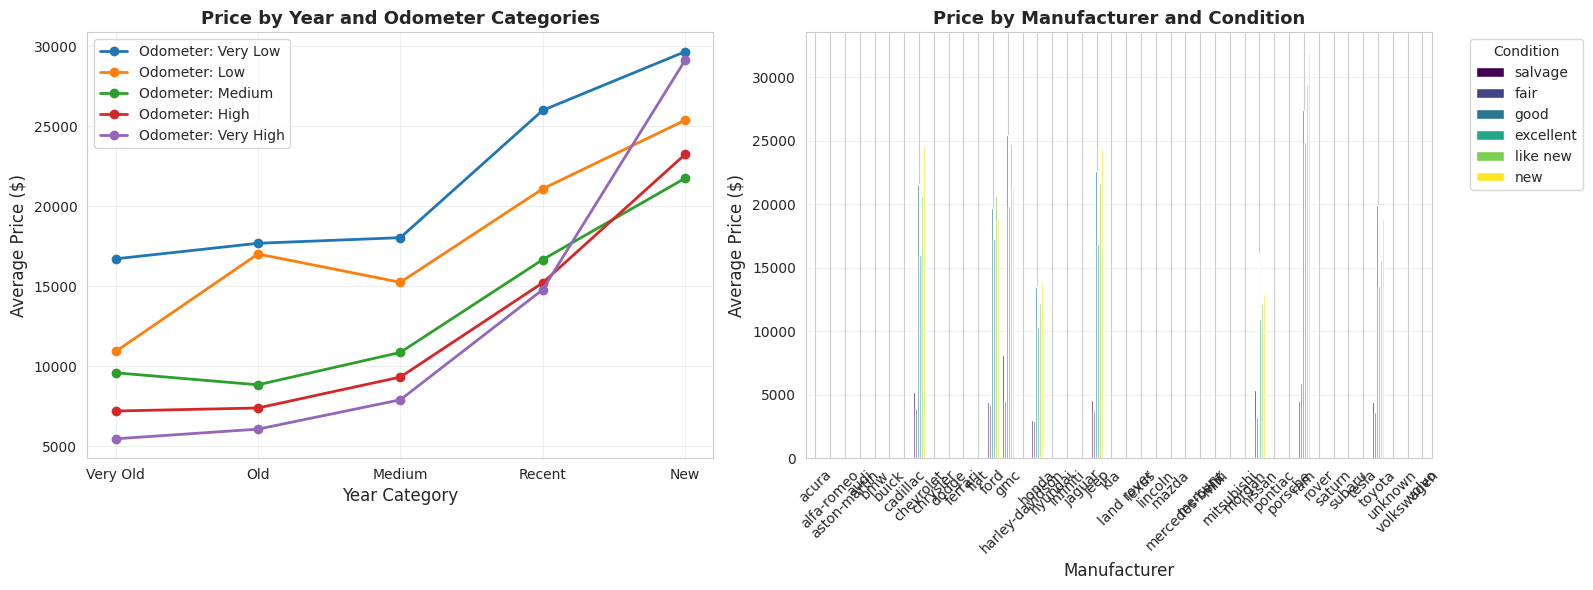

Figure saved: eda_08_feature_interactions.png


In [22]:
# Year and Odometer interaction with Price
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Create bins for year and odometer
df_sample = df.sample(min(10000, len(df)), random_state=42)

# Year bins
df_sample['year_bin'] = pd.cut(df_sample['year'], bins=5, labels=['Very Old', 'Old', 'Medium', 'Recent', 'New'])

# Odometer bins
df_sample['odometer_bin'] = pd.qcut(df_sample['odometer'], q=5, labels=['Very Low', 'Low', 'Medium', 'High', 'Very High'])

# Plot 1: Price by Year and Odometer bins
for odometer_cat in df_sample['odometer_bin'].cat.categories:
    subset = df_sample[df_sample['odometer_bin'] == odometer_cat]
    avg_prices = subset.groupby('year_bin')['price'].mean()
    axes[0].plot(avg_prices.index, avg_prices.values, marker='o', label=f'Odometer: {odometer_cat}', linewidth=2)

axes[0].set_xlabel('Year Category', fontsize=12)
axes[0].set_ylabel('Average Price ($)', fontsize=12)
axes[0].set_title('Price by Year and Odometer Categories', fontsize=13, fontweight='bold')
axes[0].legend()
axes[0].grid(alpha=0.3)

# Plot 2: Price by Manufacturer and Condition
top_manufacturers = df['manufacturer'].value_counts().head(8).index
df_subset = df[df['manufacturer'].isin(top_manufacturers)]

condition_order = ['salvage', 'fair', 'good', 'excellent', 'like new', 'new']
available_conditions = [c for c in condition_order if c in df_subset['condition'].unique()]

price_by_mfr_cond = df_subset.groupby(['manufacturer', 'condition'])['price'].mean().unstack(fill_value=0)
price_by_mfr_cond = price_by_mfr_cond[available_conditions] if len(available_conditions) > 0 else price_by_mfr_cond

price_by_mfr_cond.plot(kind='bar', ax=axes[1], width=0.8, colormap='viridis')
axes[1].set_xlabel('Manufacturer', fontsize=12)
axes[1].set_ylabel('Average Price ($)', fontsize=12)
axes[1].set_title('Price by Manufacturer and Condition', fontsize=13, fontweight='bold')
axes[1].legend(title='Condition', bbox_to_anchor=(1.05, 1), loc='upper left')
axes[1].tick_params(axis='x', rotation=45)
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig(os.path.join(RESULTS_FIGURES, 'eda_08_feature_interactions.png'), dpi=300, bbox_inches='tight')
plt.show()

print("Figure saved: eda_08_feature_interactions.png")

## **6. Geographic Analysis**

In [23]:
# Price by state
state_stats = df.groupby('state')['price'].agg(['mean', 'median', 'count']).sort_values('mean', ascending=False)

print("Top 15 States by Average Price:")
print("=" * 60)
print(state_stats.head(15).to_string())
print("=" * 60)

Top 15 States by Average Price:
          mean   median  count
state                         
ak    30897.28 34399.50     54
hi    28235.79 25997.00     33
wv    24762.72 25990.00    902
mt    23372.68 21999.00   5315
mo    21947.90 19864.50   3568
wy    21930.92 19990.00    501
wa    21372.65 18000.00  10540
ut    21179.31 17995.00    955
ar    21137.11 18750.00   2953
al    20898.36 20590.00   4355
sc    20729.96 18900.00   4761
nm    20482.64 18590.00   3228
tx    20184.07 18777.00  19077
ok    20148.34 17990.00   5031
tn    19969.02 18250.00   9631


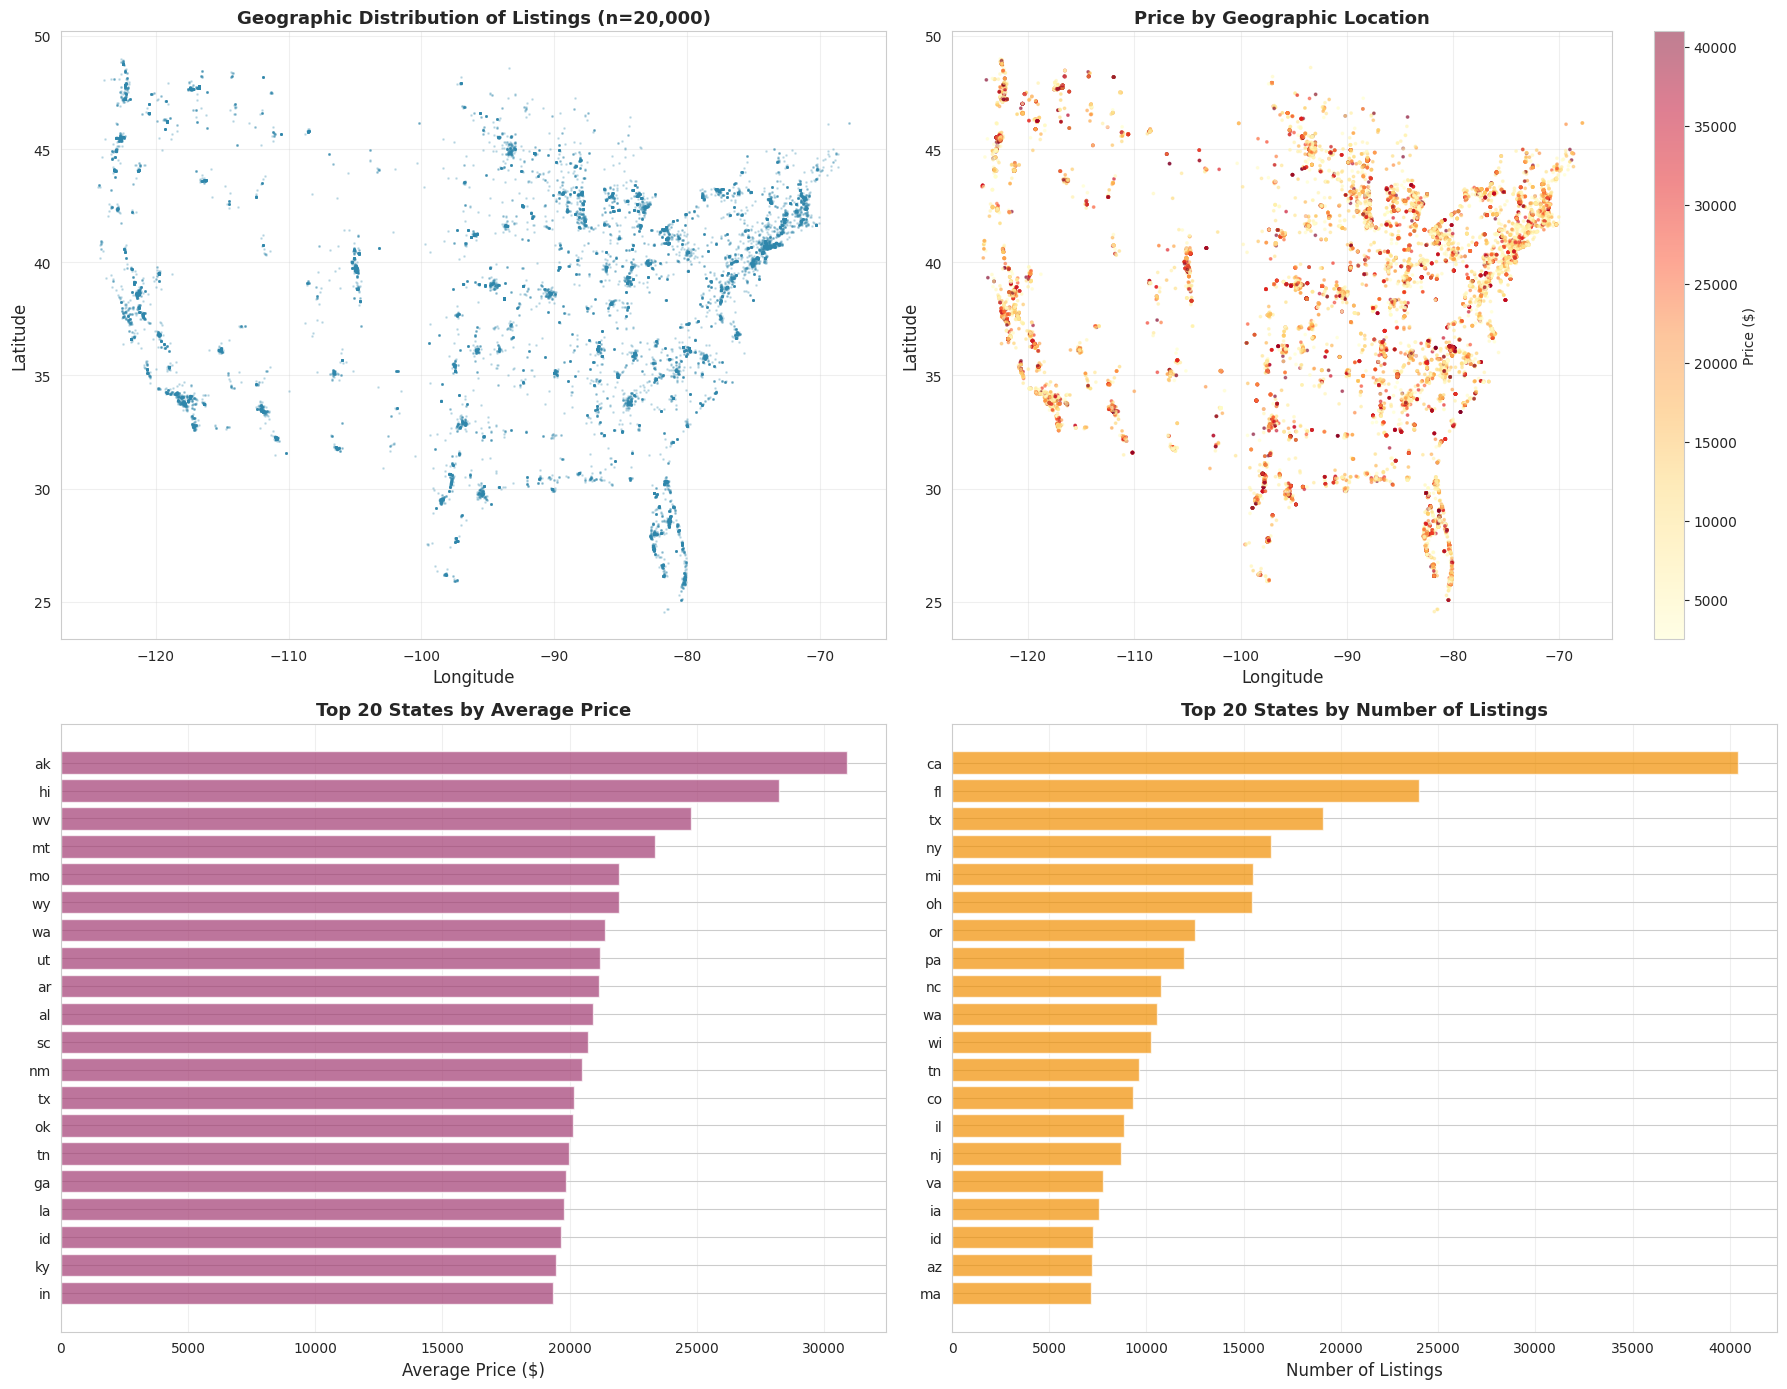

Figure saved: eda_09_geographic_analysis.png


In [24]:
# Geographic visualizations
fig, axes = plt.subplots(2, 2, figsize=(18, 14))

# Sample data for performance
sample_size = min(20000, len(df))
df_geo_sample = df.sample(sample_size, random_state=42)

# Plot 1: Geographic distribution of listings
axes[0, 0].scatter(df_geo_sample['long'], df_geo_sample['lat'],
                   alpha=0.2, s=1, color=COLORS['primary'])
axes[0, 0].set_xlabel('Longitude', fontsize=12)
axes[0, 0].set_ylabel('Latitude', fontsize=12)
axes[0, 0].set_title(f'Geographic Distribution of Listings (n={sample_size:,})',
                     fontsize=13, fontweight='bold')
axes[0, 0].grid(alpha=0.3)

# Plot 2: Price heatmap by location
scatter = axes[0, 1].scatter(df_geo_sample['long'], df_geo_sample['lat'],
                             c=df_geo_sample['price'], cmap='YlOrRd',
                             alpha=0.5, s=3, vmin=df['price'].quantile(0.05),
                             vmax=df['price'].quantile(0.95))
axes[0, 1].set_xlabel('Longitude', fontsize=12)
axes[0, 1].set_ylabel('Latitude', fontsize=12)
axes[0, 1].set_title('Price by Geographic Location', fontsize=13, fontweight='bold')
plt.colorbar(scatter, ax=axes[0, 1], label='Price ($)')
axes[0, 1].grid(alpha=0.3)

# Plot 3: Average price by state (top 20)
top_20_states = state_stats.head(20)
axes[1, 0].barh(range(len(top_20_states)), top_20_states['mean'].values,
                color=COLORS['secondary'], alpha=0.7)
axes[1, 0].set_yticks(range(len(top_20_states)))
axes[1, 0].set_yticklabels(top_20_states.index)
axes[1, 0].set_xlabel('Average Price ($)', fontsize=12)
axes[1, 0].set_title('Top 20 States by Average Price', fontsize=13, fontweight='bold')
axes[1, 0].invert_yaxis()
axes[1, 0].grid(axis='x', alpha=0.3)

# Plot 4: Number of listings by state (top 20)
top_20_states_count = df['state'].value_counts().head(20)
axes[1, 1].barh(range(len(top_20_states_count)), top_20_states_count.values,
                color=COLORS['accent'], alpha=0.7)
axes[1, 1].set_yticks(range(len(top_20_states_count)))
axes[1, 1].set_yticklabels(top_20_states_count.index)
axes[1, 1].set_xlabel('Number of Listings', fontsize=12)
axes[1, 1].set_title('Top 20 States by Number of Listings', fontsize=13, fontweight='bold')
axes[1, 1].invert_yaxis()
axes[1, 1].grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.savefig(os.path.join(RESULTS_FIGURES, 'eda_09_geographic_analysis.png'), dpi=300, bbox_inches='tight')
plt.show()

print("Figure saved: eda_09_geographic_analysis.png")

## **7. Temporal Analysis**

In [25]:
# Check the raw posting_date values (before conversion)
print("Raw posting_date values (as loaded from CSV):")
print(df['posting_date'].dtype)
print("\nFirst 20 values:")
print(df['posting_date'].head(20))
print("\nUnique value examples (first 50):")
print(df['posting_date'].unique()[:50])
print("\nValue counts (top 20):")
print(df['posting_date'].value_counts().head(20))

Raw posting_date values (as loaded from CSV):
datetime64[ns]

First 20 values:
0    2021-05-04
1    2021-05-04
2    2021-05-04
3    2021-05-04
4    2021-05-03
5    2021-05-03
6    2021-05-03
7    2021-05-03
8    2021-05-03
9    2021-05-03
10   2021-05-02
11   2021-05-02
12   2021-05-02
13   2021-05-02
14   2021-05-01
15   2021-05-01
16   2021-05-01
17   2021-05-01
18   2021-04-30
19   2021-04-30
Name: posting_date, dtype: datetime64[ns]

Unique value examples (first 50):
<DatetimeArray>
['2021-05-04 00:00:00', '2021-05-03 00:00:00', '2021-05-02 00:00:00',
 '2021-05-01 00:00:00', '2021-04-30 00:00:00', '2021-04-29 00:00:00',
 '2021-04-28 00:00:00', '2021-04-27 00:00:00', '2021-04-26 00:00:00',
 '2021-04-25 00:00:00', '2021-04-24 00:00:00', '2021-04-23 00:00:00',
 '2021-04-22 00:00:00', '2021-04-21 00:00:00', '2021-04-20 00:00:00',
 '2021-04-19 00:00:00', '2021-04-18 00:00:00', '2021-04-17 00:00:00',
 '2021-04-16 00:00:00', '2021-04-15 00:00:00', '2021-04-14 00:00:00',
 '2021-04-13 00:00

In [26]:
# Check for any non-standard values
print("Checking for problematic values...")
print(f"\nTotal records: {len(df)}")
print(f"Unique posting_date values: {df['posting_date'].nunique()}")

# Check for empty/null-like strings
empty_count = (df['posting_date'] == '').sum()
nat_count = (df['posting_date'] == 'NaT').sum()
none_count = (df['posting_date'].isna()).sum()
nan_str_count = (df['posting_date'] == 'nan').sum()

print(f"\nEmpty strings: {empty_count}")
print(f"'NaT' strings: {nat_count}")
print(f"None/NaN: {none_count}")
print(f"'nan' strings: {nan_str_count}")

# Check value lengths (dates should be consistent length)
print(f"\nString length distribution:")
print(df['posting_date'].astype(str).str.len().value_counts().head(10))

# Sample some values that might be problematic
print("\nLast 20 values:")
print(df['posting_date'].tail(20))

Checking for problematic values...

Total records: 348001
Unique posting_date values: 32

Empty strings: 0
'NaT' strings: 0
None/NaN: 0
'nan' strings: 0

String length distribution:
posting_date
10    348001
Name: count, dtype: int64

Last 20 values:
347981   2021-04-05
347982   2021-04-05
347983   2021-04-05
347984   2021-04-05
347985   2021-04-05
347986   2021-04-05
347987   2021-04-05
347988   2021-04-05
347989   2021-04-05
347990   2021-04-04
347991   2021-04-04
347992   2021-04-04
347993   2021-04-04
347994   2021-04-04
347995   2021-04-04
347996   2021-04-04
347997   2021-04-04
347998   2021-04-04
347999   2021-04-04
348000   2021-04-04
Name: posting_date, dtype: datetime64[ns]


In [29]:
# Convert posting_date from object to datetime
df['posting_date'] = pd.to_datetime(df['posting_date'], errors='coerce')

# Verify the conversion
print(f"posting_date dtype: {df['posting_date'].dtype}")
print(f"Sample values:")
print(df['posting_date'].head())
print(f"\nNull values after conversion: {df['posting_date'].isna().sum()}")

posting_date dtype: datetime64[ns]
Sample values:
0   2021-05-04
1   2021-05-04
2   2021-05-04
3   2021-05-04
4   2021-05-03
Name: posting_date, dtype: datetime64[ns]

Null values after conversion: 0


In [30]:
# Extract temporal features
df['posting_month'] = df['posting_date'].dt.month
df['posting_day_of_week'] = df['posting_date'].dt.dayofweek
df['posting_year_month'] = df['posting_date'].dt.to_period('M')

print("Temporal features extracted successfully!")

Temporal features extracted successfully!


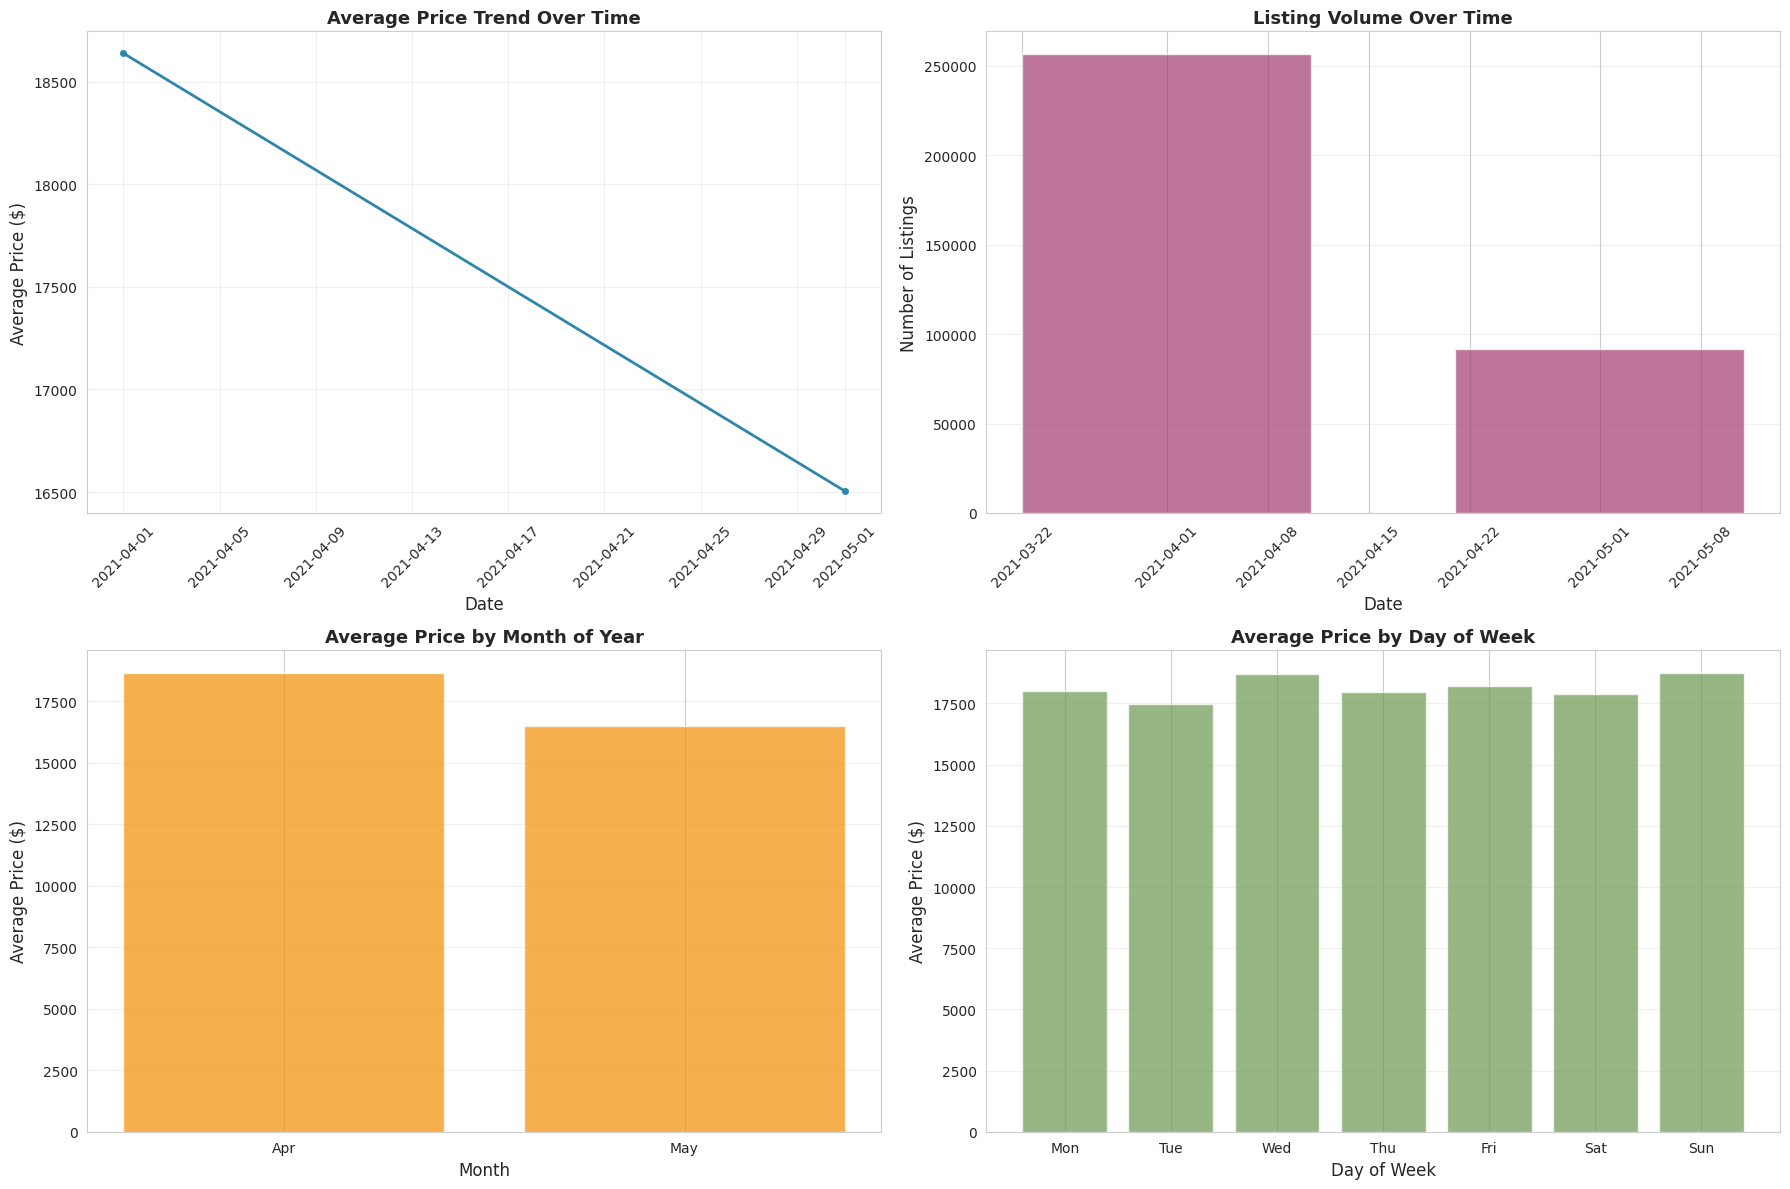

Figure saved: eda_10_temporal_analysis.png


In [32]:
# Temporal analysis visualizations
fig, axes = plt.subplots(2, 2, figsize=(18, 12))

# Plot 1: Average price over time (monthly)
monthly_price = df.groupby('posting_year_month')['price'].agg(['mean', 'count'])
monthly_price.index = monthly_price.index.to_timestamp()

axes[0, 0].plot(monthly_price.index, monthly_price['mean'],
                color=COLORS['primary'], linewidth=2, marker='o', markersize=4)
axes[0, 0].set_xlabel('Date', fontsize=12)
axes[0, 0].set_ylabel('Average Price ($)', fontsize=12)
axes[0, 0].set_title('Average Price Trend Over Time', fontsize=13, fontweight='bold')
axes[0, 0].grid(alpha=0.3)
axes[0, 0].tick_params(axis='x', rotation=45)

# Plot 2: Number of listings over time
axes[0, 1].bar(monthly_price.index, monthly_price['count'],
               color=COLORS['secondary'], alpha=0.7, width=20)
axes[0, 1].set_xlabel('Date', fontsize=12)
axes[0, 1].set_ylabel('Number of Listings', fontsize=12)
axes[0, 1].set_title('Listing Volume Over Time', fontsize=13, fontweight='bold')
axes[0, 1].grid(axis='y', alpha=0.3)
axes[0, 1].tick_params(axis='x', rotation=45)

# Plot 3: Average price by month of year
month_names = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
monthly_avg = df.groupby('posting_month')['price'].mean()

# Only plot the months that exist in the data
months_in_data = monthly_avg.index.tolist()
month_labels = [month_names[m-1] for m in months_in_data]

axes[1, 0].bar(months_in_data, monthly_avg.values, color=COLORS['accent'], alpha=0.7)
axes[1, 0].set_xticks(months_in_data)
axes[1, 0].set_xticklabels(month_labels)
axes[1, 0].set_xlabel('Month', fontsize=12)
axes[1, 0].set_ylabel('Average Price ($)', fontsize=12)
axes[1, 0].set_title('Average Price by Month of Year', fontsize=13, fontweight='bold')
axes[1, 0].grid(axis='y', alpha=0.3)

# Plot 4: Average price by day of week
day_names = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
daily_avg = df.groupby('posting_day_of_week')['price'].mean()

axes[1, 1].bar(range(7), daily_avg.values, color=COLORS['success'], alpha=0.7)
axes[1, 1].set_xticks(range(7))
axes[1, 1].set_xticklabels(day_names)
axes[1, 1].set_xlabel('Day of Week', fontsize=12)
axes[1, 1].set_ylabel('Average Price ($)', fontsize=12)
axes[1, 1].set_title('Average Price by Day of Week', fontsize=13, fontweight='bold')
axes[1, 1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig(os.path.join(RESULTS_FIGURES, 'eda_10_temporal_analysis.png'), dpi=300, bbox_inches='tight')
plt.show()

print("Figure saved: eda_10_temporal_analysis.png")

## **8. Key Insights Summary**

In [33]:
# Generate comprehensive insights
print("=" * 80)
print("KEY INSIGHTS FROM EXPLORATORY DATA ANALYSIS")
print("=" * 80)

print("\n1. TARGET VARIABLE (PRICE):")
print("-" * 80)
print(f"   - Mean: ${df['price'].mean():,.2f}")
print(f"   - Median: ${df['price'].median():,.2f}")
print(f"   - Std Dev: ${df['price'].std():,.2f}")
print(f"   - Skewness: {df['price'].skew():.3f} (right-skewed distribution)")
print(f"   - Price range: ${df['price'].min():,.0f} - ${df['price'].max():,.0f}")

print("\n2. STRONGEST CORRELATIONS WITH PRICE:")
print("-" * 80)
price_correlations = df[numerical_cols].corr()['price'].sort_values(ascending=False)
for feature, corr in price_correlations.items():
    if feature != 'price':
        direction = 'positive' if corr > 0 else 'negative'
        strength = 'strong' if abs(corr) > 0.5 else 'moderate' if abs(corr) > 0.3 else 'weak'
        print(f"   - {feature}: {corr:.3f} ({strength} {direction})")

print("\n3. CATEGORICAL FEATURES IMPACT:")
print("-" * 80)
for feature in ['manufacturer', 'condition', 'fuel', 'type']:
    if feature in df.columns:
        top_cat = df.groupby(feature)['price'].mean().sort_values(ascending=False).head(3)
        print(f"   {feature.upper()} - Top 3 by avg price:")
        for cat, price in top_cat.items():
            print(f"      {cat}: ${price:,.2f}")

print("\n4. GEOGRAPHIC INSIGHTS:")
print("-" * 80)
top_states = state_stats.head(5)
print("   Top 5 states by average price:")
for state, row in top_states.iterrows():
    print(f"      {state}: ${row['mean']:,.2f} (n={row['count']:,})")

print("\n5. TEMPORAL PATTERNS:")
print("-" * 80)
highest_month = monthly_avg.idxmax()
lowest_month = monthly_avg.idxmin()
print(f"   - Highest avg price month: {month_names[highest_month-1]} (${monthly_avg[highest_month]:,.2f})")
print(f"   - Lowest avg price month: {month_names[lowest_month-1]} (${monthly_avg[lowest_month]:,.2f})")
print(f"   - Seasonal variation: ${monthly_avg.max() - monthly_avg.min():,.2f}")

print("\n6. DATA QUALITY:")
print("-" * 80)
print(f"   - Total records: {len(df):,}")
print(f"   - Total features: {len(df.columns)}")
print(f"   - Missing values: {df.isna().sum().sum()} (complete dataset)")
print(f"   - Duplicate records: 0 (removed in cleaning)")

print("\n" + "=" * 80)

KEY INSIGHTS FROM EXPLORATORY DATA ANALYSIS

1. TARGET VARIABLE (PRICE):
--------------------------------------------------------------------------------
   - Mean: $18,077.00
   - Median: $15,400.00
   - Std Dev: $12,595.23
   - Skewness: 0.693 (right-skewed distribution)
   - Price range: $150 - $56,255

2. STRONGEST CORRELATIONS WITH PRICE:
--------------------------------------------------------------------------------
   - year: 0.600 (strong positive)
   - lat: -0.035 (weak negative)
   - long: -0.040 (weak negative)
   - odometer: -0.563 (strong negative)

3. CATEGORICAL FEATURES IMPACT:
--------------------------------------------------------------------------------
   MANUFACTURER - Top 3 by avg price:
      tesla: $35,961.72
      alfa-romeo: $30,155.62
      ram: $28,295.10
   CONDITION - Top 3 by avg price:
      good: $21,349.63
      unknown: $18,244.67
      new: $18,045.15
   FUEL - Top 3 by avg price:
      diesel: $29,474.43
      other: $26,672.37
      electric: $24